In [1]:
import numpy as np
import healpy as hp
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from scripts.cosine_smoothed_mask import cosine_smoothed_mask
from scripts.compute_covariance import compute_covariance
from scripts.mask_maps import mask_maps
from scripts.compute_decoupled_cl import compute_decoupled_cl

In [2]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
# nfreqs=len(freqs)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)
r=3 #foreground model rank
# n_bins=10

In [238]:
def compute_decoupled_cl_2( maps: np.ndarray, masks:np.ndarray, nsides:int, l_max:int, n_freq:int)-> np.ndarray:
    """
    Compute the power spectra using NaMaster for a set of frequency maps.

    Parameters:
    - maps: numpy array of shape (n_freqs, n_maps) containing the frequency maps
    - masks: mask to apply to the maps
    - X: flag to indicate if the input maps are masked
    - nsides: resolution parameter for the maps
    - l_max: maximum multipole for the power spectra
    - n_freq: number of frequency channels

    Returns:
    - p_cl: raw power spectrum (coupled)
    - matrix: mode coupling matrix
    - cldec: decoupled power spectrum
    """

    cldec = np.zeros((l_max//10, n_freq, n_freq))
    

    # Loop over all pairs of frequency maps (cross-power spectra)
    for i in range(n_freq):
        print ("processing map %d" % i)
        for j in range(i, n_freq):  # Compute only upper triangle (symmetric matrix)
            
            # Define the masked fields for the two maps
            f_i = nmt.NmtField(masks, [maps[i, :]], lmax=l_max) 
            f_j = nmt.NmtField( masks, [maps[j, :]], lmax=l_max) 
            
            # Define a NaMaster binning scheme (no binning)
            b = nmt.NmtBin.from_lmax_linear(l_max, 10)
            
            cldec[:,i,j]=nmt.compute_full_master(f_i, f_j, b)

            if i != j:
                cldec[:, j, i] = cldec[:, i, j]
    leff = b.get_effective_ells()
    return leff,cldec

In [ ]:
# ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
# sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
# hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/calibrated_hi_maps.npy")*100
# noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")

In [3]:
ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_ff_maps.npy")
sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_sync_maps.npy")
hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_hi_maps.npy")*100
noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")

In [189]:
noise_maps_1=noise_maps*1e4 # take only first chunk
#1e4 gives better results

In [5]:
sync.shape

(55, 786432)

In [208]:
fgds=sync/1e6 +ff
signal=fgds[:54] + hi_maps

In [209]:
mask = cosine_smoothed_mask(nside)

In [210]:
fgds_masked,_= mask_maps(fgds, mask,almsize, lmax, nfreqs,  npix)
hi_masked,_= mask_maps(hi_maps, mask,almsize, lmax, nfreqs,  npix)
noise_masked,_= mask_maps(noise_maps_1, mask,almsize, lmax, nfreqs,  npix)

In [211]:
cl_noise= compute_covariance(noise_maps_1, lmax, almsize, nfreqs)
cl_fgds= compute_covariance(fgds, lmax, almsize, nfreqs)
cl_hi=compute_covariance(hi_maps, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [ ]:
# dec_noise= compute_decoupled_cl_2(noise_masked, mask, nside, lmax, nfreqs)
# dec_fgds= compute_decoupled_cl_2(fgds_masked, mask, nside, lmax, nfreqs)
# dec_hi= compute_decoupled_cl_2(hi_masked, mask, nside, lmax, nfreqs)

processing map 0
processing map 1
processing map 2
processing map 3
processing map 4
processing map 5
processing map 6
processing map 7
processing map 8
processing map 9
processing map 10
processing map 11
processing map 12
processing map 13
processing map 14
processing map 15
processing map 16
processing map 17
processing map 18
processing map 19
processing map 20
processing map 21
processing map 22
processing map 23
processing map 24
processing map 25
processing map 26
processing map 27
processing map 28
processing map 29
processing map 30
processing map 31
processing map 32
processing map 33
processing map 34
processing map 35
processing map 36
processing map 37
processing map 38
processing map 39
processing map 40
processing map 41
processing map 42
processing map 43
processing map 44
processing map 45
processing map 46
processing map 47
processing map 48
processing map 49
processing map 50
processing map 51
processing map 52
processing map 53
processing map 0
processing map 1
proc

KeyboardInterrupt: 

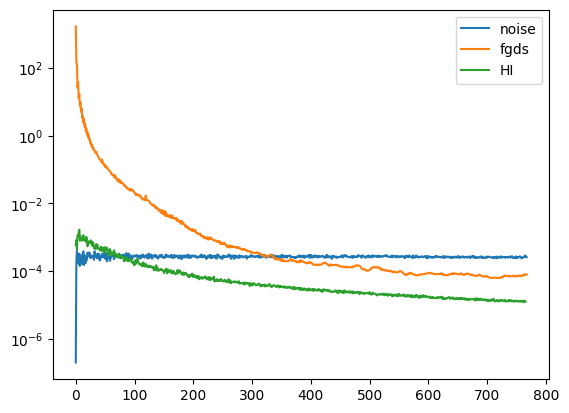

In [239]:
plt.plot(cl_noise[:,0,0], label='noise')
plt.plot(cl_fgds[:,0,0], label='fgds')
plt.plot(cl_hi[2:,0,0], label='HI')
plt.yscale('log')
plt.legend()

In [8]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((lmax+1, nfreqs, nfreqs))
    for l in range (lmax+1):
        print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag

In [213]:
noise_d= diagonalize_matrices(cl_noise, nfreqs)
hi_d= diagonalize_matrices(cl_noise, nfreqs)

Diagonalizing matrix 0
Diagonalizing matrix 1
Diagonalizing matrix 2
Diagonalizing matrix 3
Diagonalizing matrix 4
Diagonalizing matrix 5
Diagonalizing matrix 6
Diagonalizing matrix 7
Diagonalizing matrix 8
Diagonalizing matrix 9
Diagonalizing matrix 10
Diagonalizing matrix 11
Diagonalizing matrix 12
Diagonalizing matrix 13
Diagonalizing matrix 14
Diagonalizing matrix 15
Diagonalizing matrix 16
Diagonalizing matrix 17
Diagonalizing matrix 18
Diagonalizing matrix 19
Diagonalizing matrix 20
Diagonalizing matrix 21
Diagonalizing matrix 22
Diagonalizing matrix 23
Diagonalizing matrix 24
Diagonalizing matrix 25
Diagonalizing matrix 26
Diagonalizing matrix 27
Diagonalizing matrix 28
Diagonalizing matrix 29
Diagonalizing matrix 30
Diagonalizing matrix 31
Diagonalizing matrix 32
Diagonalizing matrix 33
Diagonalizing matrix 34
Diagonalizing matrix 35
Diagonalizing matrix 36
Diagonalizing matrix 37
Diagonalizing matrix 38
Diagonalizing matrix 39
Diagonalizing matrix 40
Diagonalizing matrix 41
Di

In [195]:
delta_ell=10

In [214]:
def bin_spectra(cl,nside, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [242]:
leff,n_bins, noise_binned= bin_spectra(noise_d, nside, delta_ell)
*_, fgds_binned= bin_spectra(cl_fgds, nside, delta_ell)
*_, hi_binned= bin_spectra(cl_hi, nside, delta_ell)

In [ ]:
# np.save('fgds_binned.npy', fgds_binned)
# np.save('noise_binned.npy', noise_binned)

In [216]:
total=signal + noise_maps_1[:54]

In [698]:
total.shape

(54, 786432)

In [217]:
masked_maps,_ = mask_maps(total, mask, almsize,lmax, nfreqs, npix)

In [236]:
c_dec= compute_decoupled_cl_2(masked_maps, mask, nside, lmax,nfreqs)

processing map 0
processing map 1
processing map 2
processing map 3
processing map 4
processing map 5
processing map 6
processing map 7
processing map 8
processing map 9
processing map 10
processing map 11
processing map 12
processing map 13
processing map 14
processing map 15
processing map 16
processing map 17
processing map 18
processing map 19
processing map 20
processing map 21
processing map 22
processing map 23
processing map 24
processing map 25
processing map 26
processing map 27
processing map 28
processing map 29
processing map 30
processing map 31
processing map 32
processing map 33
processing map 34
processing map 35
processing map 36
processing map 37
processing map 38
processing map 39
processing map 40
processing map 41
processing map 42
processing map 43
processing map 44
processing map 45
processing map 46
processing map 47
processing map 48
processing map 49
processing map 50
processing map 51
processing map 52
processing map 53


In [237]:
np.save('dec_empirical.npy', c_dec)

In [220]:
c_dec.shape

(766, 54, 54)

In [ ]:
# c_l_hat= compute_covariance(total, lmax, almsize, 54)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [221]:
def bin_spectra_2(cl,nside, delta):
    l_max = cl.shape[0] - 1
    b= nmt.NmtBin.from_lmax_linear(l_max, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [ ]:
# *_,c_bin= (bin_spectra(np.real(c_l_hat), nside, delta_ell))
# *_,c_bin= (bin_spectra_2(np.real(c_dec), nside, delta_ell))

In [223]:
c_bin.shape

(76, 54, 54)

In [224]:
c_hat=np.zeros((n_bins, nfreqs, nfreqs)) #clip any eigenvalues that are negative and put to zerp
for b in range(n_bins):
    
    cov = 0.5 * (c_bin[b] + c_bin[b].T) #symmetric or Hermitian?

    # Eigen-decomposition (since it's symmetric, use eigh)
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Zero out negative eigenvalues
    eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
    
    epsilon=1e-10

    # Reconstruct the covariance matrix
    c_hat[b] = (eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T)#+ epsilon*np.identity(nfreqs) 


In [ ]:
# np.save('binned_empirical.npy', c_hat)

In [203]:
np.all(eigvals_clipped >= 0)

np.True_

In [240]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(c_hat))

Is model PSD? True


In [161]:
def pca(empirical, r, f):
    """
    Perform PCA on the covariance matrix.
    
    Parameters:
    ----------
    c_hat : np.ndarray
        Covariance matrix of shape (n_bins, n_freq, n_freq).
    
    r : int
        Number of principal components to retain.
    
    Returns:
    -------
    F : np.ndarray
        Matrix of shape (n_freq, r) containing the principal components.
    
    P_b : np.ndarray
        Matrix of shape (n_bins, r, r) containing the eigenvalues and eigenvectors.
    """
    # Perform PCA
    R_global = np.mean(empirical, axis=0)  # c_hat has shape (n_bins, n_freqs, n_freqs)
    #eigen decompositiom
    eigvals, eigvecs = np.linalg.eigh(R_global) #ascending order
    #Take the top r eigenvectors:
    F_i = eigvecs[:, -r:]  # largest eigenvectors
    epsilon=1e-6

    P_b = np.zeros((n_bins, r, r))
    for b in range(n_bins):
        P_b[b] =np.dot( F_i.T , np.dot(empirical[b] , F_i)) #projecting the empirical covariance into the subspace spanned by F.
        P_b[b] = 0.5 * (P_b[b] + P_b[b].T) + epsilon * np.eye(r)
    return eigvals,F_i, P_b*f


In [162]:
factor=550

In [246]:
_,F_pca, P_b_pca = pca(c_dec,r, factor)
# F_pca, P_b_pca = guess_params(nfreqs, n_bins,r)
# e,F_pca, P_b_pca = pca_extended_random_fill(c_hat,5,2)
print(F_pca.shape)
print(P_b_pca.shape)
params_pca = np.concatenate([F_pca.flatten(), P_b_pca.flatten()])
print(params_pca.shape)



(54, 3)
(76, 3, 3)
(846,)


In [ ]:
# # Check recovery
# F_re = params_pca[:nfreqs * r].reshape((nfreqs, r))
# P_b_re = params_pca[nfreqs * r:].reshape((n_bins, r, r))
# print(F_re.shape)
# print(P_b_re.shape)
# print(F_re.size)
# print(P_b_re.size)

# np.allclose(F_pca, F_re)  # should return True
# np.allclose(P_b_pca, P_b_re)  # should return True

In [85]:
def model_covariance(F, P_b,C_HI, C_noise, n_bins):
    
    # F: (N_channels, r), P_b: (r, r), C_HI & C_noise: (N_channels, N_channels)
    C_b= np.zeros((n_bins, nfreqs, nfreqs))
    for b in range(n_bins):
        C_b[b,:,:]= C_HI[b,:,:]+C_noise[b,:,:] + np.dot(F,np.dot(P_b[b,:,:], F.T))
    return C_b

In [247]:
c_model= model_covariance(F_pca, P_b_pca,hi_binned,noise_binned, n_bins)

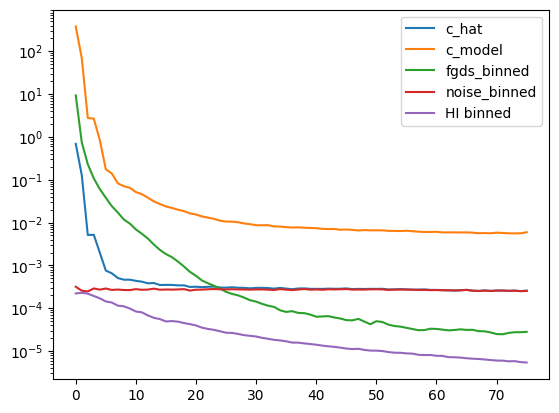

In [248]:
plt.plot(c_dec[:,10,10], label='c_hat')
plt.plot(c_model[:,10,10], label='c_model')
plt.plot(fgds_binned[:,10,10], label='fgds_binned')
plt.plot(noise_binned[:,10,10], label='noise_binned')
plt.plot(hi_binned[:,10,10], label='HI binned')
plt.yscale('log')
plt.legend()

In [131]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= tol)  
print("Is model PSD?", is_psd(c_model))

Is model PSD? True


In [93]:
def smica(params, hi,noise,empirical,  n_bins, nfreqs, r):
    
    # Reshape the flattened params back into F_init and P_b_init
    
    F_i = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((n_bins,r,r))
    
    
    """# === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])

        F[:, i] /= norm  # normalize column
        for b in range(n_bins):
            P_b[b, i, :] *= norm
            P_b[b, :, i] *= norm  # symmetric scaling"""
    
    
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
                
    # === Compute the cost function ===            
    cost=0
    # model=np.zeros((n_bins, nfreqs, nfreqs))
    # model_inv=np.zeros((n_bins, nfreqs, nfreqs))
    
    # term=np.zeros(n_bins)
    for b in range(n_bins):
        model=  hi[b]+noise[b] + np.dot(F_i, np.dot(P_b[b], F_i.T))
        model_inv= np.linalg.inv(model)
        
        sign, logdet= np.linalg.slogdet(np.dot(empirical[b],model_inv))
        trace=np.trace(np.dot(empirical[b] , model_inv))
        
        term = -logdet + trace-nfreqs
        cost += term
        
    return cost

In [132]:
smica(params_pca, hi_binned,noise_binned, c_hat, n_bins, nfreqs, r)

np.float64(965.3474972258307)

In [97]:
def norm_constraints(params, nfreqs, r, n_bins):
    F_i= params[:nfreqs * r].reshape((nfreqs, r))
    norm=np.zeros(r)
    for j in range(r):
        norm[j]=np.linalg.norm(F_i[:,j])
    return norm

In [98]:
from scipy.optimize import NonlinearConstraint

constraint = NonlinearConstraint(
    lambda params_pca: norm_constraints(params_pca, nfreqs, r, n_bins),
    lb=np.ones(r),  # lower bounds = 1
    ub=np.ones(r)   # upper bounds = 1 → equality constraint
)

In [133]:
np.linalg.norm(F_pca[:, 1])

np.float64(1.0000000000000002)

In [134]:
def jacobian_2(params, hi,noise,  empirical, n_bins, nfreqs, r):
    
    delta_ell=10
    # Reshape the flattened params back into F_init and P_b_init
    F = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((n_bins,r,r))
    
    """# === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])
        
        F[:, i] /= norm  # normalize column
        for b in range(n_bins):
            # Scale row i and column i of P_b[b] accordingly
            P_b[b, i, :] *= norm
            P_b[b, :, i] *= norm """
            
    # Compute norms of each column of F
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
    
    grad_P=np.zeros_like(P_b) # Derivative wrt P_b
    grad_F=np.zeros_like(F) # Derivative wrt F
    
    for b in range(n_bins):
        
        R= hi[b]+noise[b]+np.dot(F, np.dot(P_b[b], F.T)) # model covariance depending on only unknown parameters
        """try:
            R_inv = np.linalg.inv(R)
        except np.linalg.LinAlgError:
            # Optional: add small regularization to make model invertible
            R += 1e-6 * np.identity(nfreqs)
            R_inv = np.linalg.inv(R)"""
        R_inv= np.linalg.inv(R)
        
        Delta= R_inv - np.dot(R_inv,np.dot(empirical[b], R_inv)) #nf x nf

        # ∂φ/∂P_q 
        grad_P[b,:,:]= np.dot(F.T, np.dot(Delta, F)) # (r,r)
        # ∂φ/∂F
        grad_F += 2*np.dot(Delta, np.dot(F, P_b[b])) # (nf,r)
        
    # Flatten the gradients
    grad_P_flat = grad_P.flatten()
    grad_F_flat = grad_F.flatten()
    # print(grad_F_flat.shape)
    # print(grad_P_flat.shape)
    grad_total= np.concatenate([grad_F_flat.flatten(), grad_P_flat.flatten()])
    return grad_total

In [101]:
import autograd.numpy as np
from autograd import grad

auto_grad=grad(smica)

In [249]:
res = optimize.minimize(
    smica,
    x0=params_pca,
    args=(hi_binned, noise_binned,c_dec, n_bins, nfreqs,r),
    method='trust-constr',
    # constraints=constraint,
    jac=jacobian_2,
    options={'disp': True, 'maxiter':2000, 'gtol':1e-1, 'xtol':1e-10,'barrier_tol': 1e-6, 'verbose': 2}
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +1.2654e+03 | 1.00e+00 | 1.17e+02 | 0.00e+00 |
|   2   |   2   |   1   | +1.2654e+03 | 1.43e-01 | 1.17e+02 | 0.00e+00 |
|   3   |   3   |   3   | +1.2470e+03 | 4.63e-01 | 1.21e+02 | 0.00e+00 |
|   4   |   4   |   6   | +1.2288e+03 | 4.63e-01 | 1.64e+02 | 0.00e+00 |
|   5   |   5   |   9   | +1.2094e+03 | 4.63e-01 | 1.89e+02 | 0.00e+00 |
|   6   |   6   |  12   | +1.1887e+03 | 4.70e-01 | 2.04e+02 | 0.00e+00 |
|   7   |   7   |  15   | +1.1663e+03 | 4.86e-01 | 2.16e+02 | 0.00e+00 |
|   8   |   8   |  18   | +1.1420e+03 | 5.05e-01 | 2.27e+02 | 0.00e+00 |
|   9   |   9   |  21   | +1.1152e+03 | 5.28e-01 | 2.38e+02 | 0.00e+00 |
|  10   |  10   |  24   | +1.0856e+03 | 5.54e-01 | 2.58e+02 | 0.00e+00 |
|  11   |  11   |  27   | +1.0522e+03 | 5.85e-01 | 2.89e+02 | 0.00e+00 |
|  12   |  12   |  30   | +1.0143e+03 | 6.23e-01 | 

In [250]:
from pprint import pprint
pprint(res)

          message: The maximum number of function evaluations is exceeded.
          success: False
           status: 0
              fun: 51.46915201837015
                x: [-2.705e-03 -3.268e-03 ... -2.331e-03  2.307e-02]
              nit: 2000
             nfev: 2000
             njev: 2000
             nhev: 0
         cg_niter: 250267
     cg_stop_cond: 4
             grad: [ 1.349e-03 -2.092e-02 ...  1.819e-02 -2.615e-02]
  lagrangian_grad: [ 1.349e-03 -2.092e-02 ...  1.819e-02 -2.615e-02]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 2.4196296945620364
 constr_violation: 0
   execution_time: 272.119668006897
        tr_radius: 1.3702144794256323
   constr_penalty: 1.0
            niter: 2000


In [254]:
result=res.x
print(result.shape)
P_b_out = result[nfreqs*r:].reshape((n_bins,r,r))
F_out = result[:nfreqs*r].reshape((nfreqs, r))
print(P_b_out.shape)
print(F_out.shape)

C_result=np.zeros_like(c_dec)
for b in range(n_bins):
    
    C_result[b]=np.dot(F_out, np.dot(P_b_out[b], F_out.T))


(846,)
(76, 3, 3)
(54, 3)


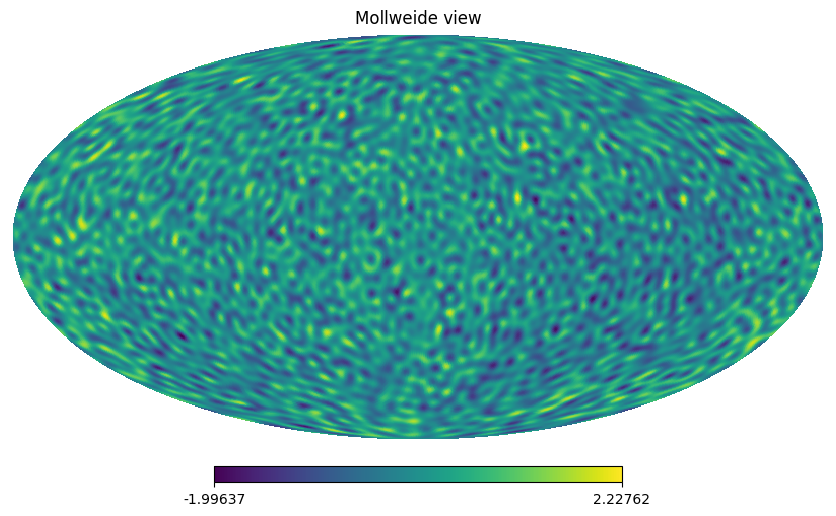

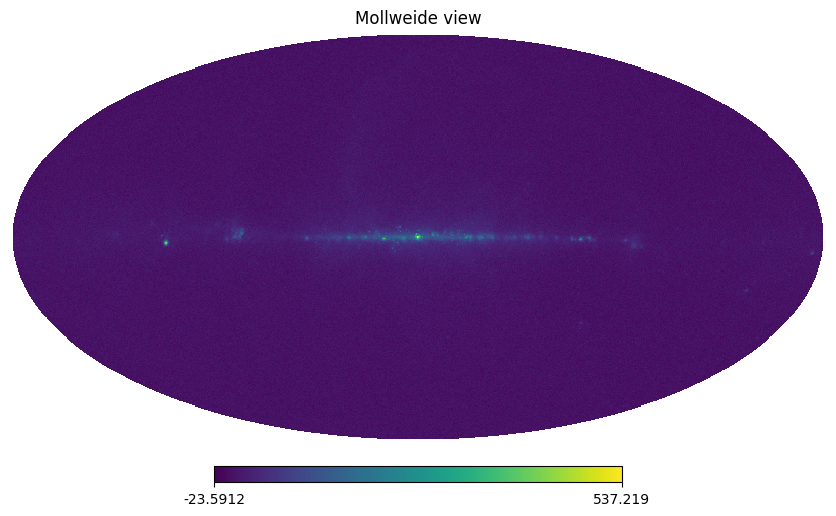

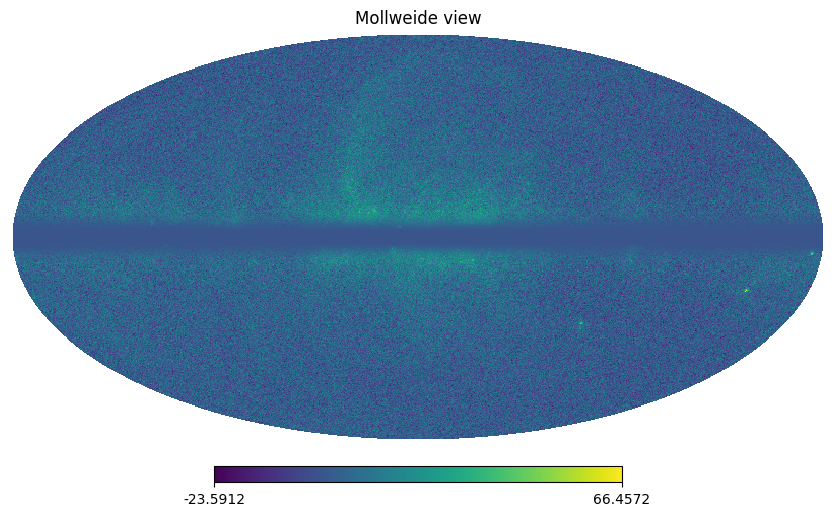

In [174]:
map=hp.synfast(C_result[:,10,10], nside)
hp.mollview(map)
hp.mollview(total[10])
hp.mollview(masked_maps[10])

In [252]:
np.all(np.linalg.eigvals(C_result) >=0)

np.True_

In [171]:
np.all(np.linalg.eigvals(P_b_out) >=0)

np.False_

In [172]:
f=30

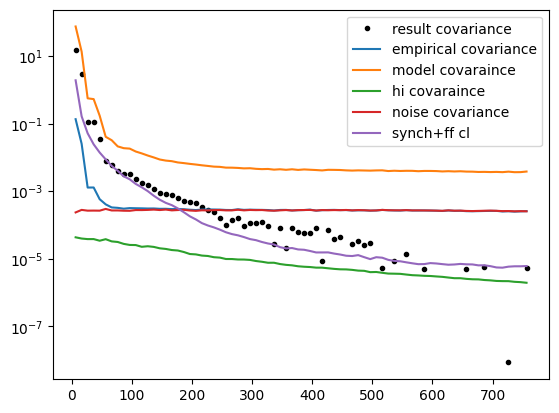

In [ ]:
plt.plot(leff,C_result[:,f,f],'k.', label="result covariance")
plt.plot(leff,c_dec[:,f,f], label="empirical covariance")
plt.plot(leff,c_model[:,f,f], label="model covaraince")
plt.plot(leff, hi_binned[:,f,f], label="hi covaraince")
plt.plot(leff,noise_binned[:,f,f], label="noise covariance")
plt.plot(leff, fgds_binned[:,f,f], label="synch+ff cl")
plt.yscale('log')
plt.legend()

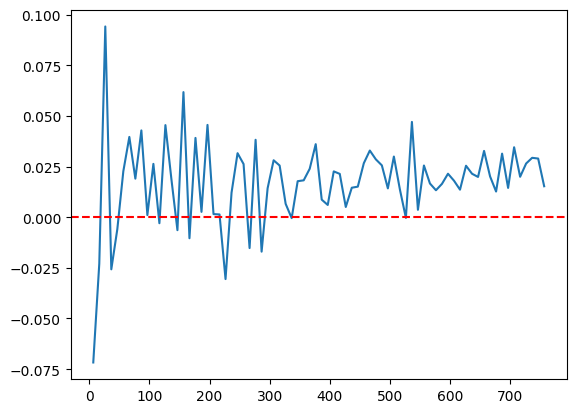

In [111]:
plt.plot(leff,(C_result[:,f,f] - c_bin[:,f,f])/c_bin[:,f,f])
# plt.plot(leff,(C_result[:,f,f] - fgds_binned[:,f,f])/fgds_binned[:,f,f])
# plt.ylim(-0.5,0.5) 
plt.axhline(0, color='r', linestyle='--')

In [112]:
leff

array([  6.5,  16.5,  26.5,  36.5,  46.5,  56.5,  66.5,  76.5,  86.5,
        96.5, 106.5, 116.5, 126.5, 136.5, 146.5, 156.5, 166.5, 176.5,
       186.5, 196.5, 206.5, 216.5, 226.5, 236.5, 246.5, 256.5, 266.5,
       276.5, 286.5, 296.5, 306.5, 316.5, 326.5, 336.5, 346.5, 356.5,
       366.5, 376.5, 386.5, 396.5, 406.5, 416.5, 426.5, 436.5, 446.5,
       456.5, 466.5, 476.5, 486.5, 496.5, 506.5, 516.5, 526.5, 536.5,
       546.5, 556.5, 566.5, 576.5, 586.5, 596.5, 606.5, 616.5, 626.5,
       636.5, 646.5, 656.5, 666.5, 676.5, 686.5, 696.5, 706.5, 716.5,
       726.5, 736.5, 746.5, 756.5])

slope of the angular power spectrum across all ℓ-bins (i.e., the spatial spectral index n) at each frequency

In [113]:
from scipy.stats import linregress

logs = np.log(leff)
powers_fg = []
powers_model = []
intercept_fg = []
intercept_model = []

for i in range(nfreqs):
    y_fg = np.log(fgds_binned[:,i,i])
    y_model = np.log(C_result[:,i,i])

    slope_fg,int_fg,*_ = linregress(logs, y_fg)
    slope_model,int_model,*_ = linregress(logs, y_model)

    powers_fg.append(slope_fg)
    powers_model.append(slope_model)
    
    intercept_fg.append(int_fg)
    intercept_model.append(int_model)
    

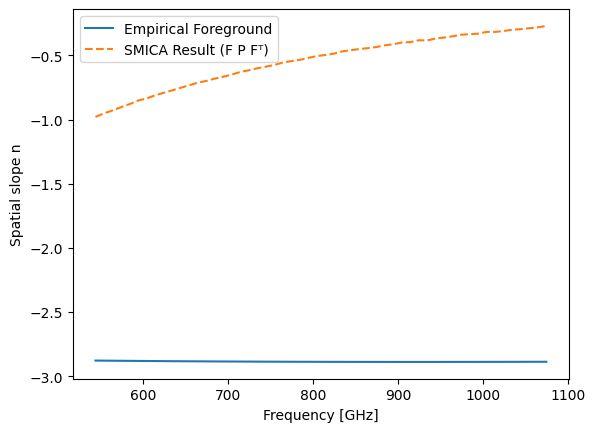

In [114]:
plt.plot(freqs[:-1],powers_fg, label='Empirical Foreground')
plt.plot(freqs[:-1],powers_model, '--', label='SMICA Result (F P Fᵀ)')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Spatial slope n')
plt.legend()


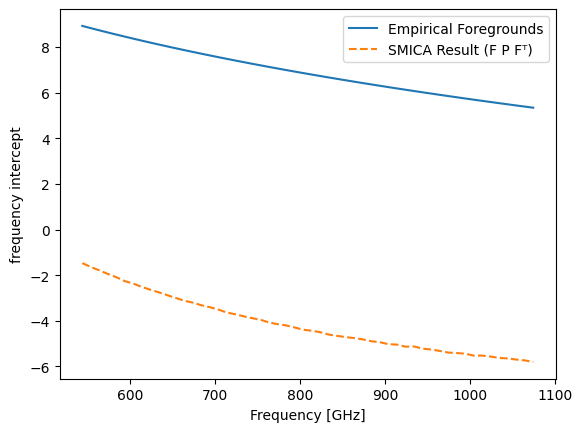

In [115]:
plt.plot(freqs[:-1],intercept_fg, label='Empirical Foregrounds')
plt.plot(freqs[:-1],intercept_model, '--', label='SMICA Result (F P Fᵀ)')
plt.xlabel('Frequency [GHz]')
plt.ylabel('frequency intercept')
plt.legend()

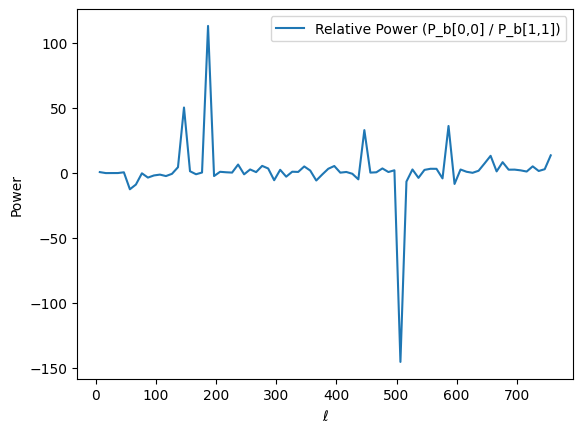

In [116]:
relative_power = P_b_out[:, 0, 0] / P_b_out[:, 1, 1]  # shape (n_bins,)
plt.plot(leff,relative_power, label='Relative Power (P_b[0,0] / P_b[1,1])')
# plt.plot(leff, P_b_out[:, 0, 0], label='Component 1')
# plt.plot(leff, P_b_out[:, 1, 1], label='Component 2')
# plt.plot(leff, P_b_out[:, 2, 2], label='Component 3')
# plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'Power')
plt.legend()